In [2]:
from astropy.io import fits
from matplotlib import pyplot as plt
import numpy as np
import glob
import os
from matplotlib import cm
from __future__ import print_function
import numpy.testing as npt
from astropy.wcs import WCS
import sys


In [3]:
sys.path.insert(1, './sip2pv1')
import sip_to_pv
import pv_to_sip


In [4]:
#some path and names:
path_to_bias = './RAW/20211202/BIAS/'
path_to_flat = './RAW/20211202/FLAT/'
path_to_obj = './RAW/20211202/clusters_XAO/'
path_to_reduc = './RAW/20211202/reduc/'
path_to_astrofile = './astrofiles/'
band = ['R','ha']
#band = ['B','ha']

band = ['Ha','B']

DETECT_THRESH=1

target_name = np.array(['NGC2146', 'LC01'])
target_ra = np.array(['06:18:37.71', '04:12:44'])
target_dec = np.array(['+78:21:25.3', '-06:31:23'])


In [5]:
#median the bias
biasfiles=glob.glob(path_to_bias+'BIAS*fits')
allbias=[]
for i,ibias in enumerate(biasfiles):
    data=fits.getdata(ibias)
    allbias.append(data)
allbias=np.stack(allbias)
superbias=np.median(allbias,axis=0)
fits.writeto(path_to_bias+'bias.fit',superbias.astype('float32'),overwrite=True)

In [6]:
allbias.shape

(10, 2000, 2064)

Text(0.5, 1.0, 'bias drived from bias frames')

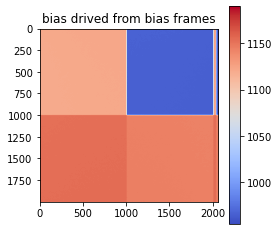

In [7]:
# check the bias
plt.figure(figsize=(4,4))
plt.imshow(superbias,cmap=cm.coolwarm)
plt.colorbar()
plt.title("bias drived from bias frames")

In [8]:
flat=glob.glob(path_to_flat+"FLAT_"+str(band[0])+"*.fits")
allflat=[]
flat

['./RAW/20211202/FLAT/FLAT_Ha_20211203005655_5s_0181.fits',
 './RAW/20211202/FLAT/FLAT_Ha_20211203005814_3s_0183.fits',
 './RAW/20211202/FLAT/FLAT_Ha_20211203005923_3s_0185.fits',
 './RAW/20211202/FLAT/FLAT_Ha_20211203005847_3s_0184.fits',
 './RAW/20211202/FLAT/FLAT_Ha_20211203005740_4s_0182.fits']

Text(0.5, 1.0, 'flat 0')

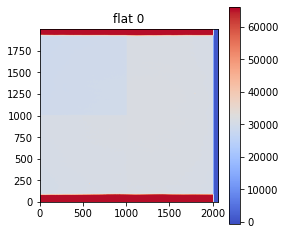

In [9]:
## check flat
plt.figure(figsize=(4,4))
plt.imshow(fits.getdata(flat[0]),vmin = fits.getdata(flat[0]).mean() - 3*fits.getdata(flat[0]).std(),vmax = fits.getdata(flat[0]).mean() + 3*fits.getdata(flat[0]).std(), origin='lower',cmap = cm.coolwarm)
plt.colorbar()
plt.title("flat 0")


In [10]:
data.shape

(2000, 2064)

In [11]:
#for each band, sub bias from each flat:

for i_band, iband in enumerate(band):
    flat=glob.glob(path_to_flat+"FLAT_"+iband+"*.fits")
    allflat=[]
    
    for i_flat, iflat in enumerate(flat):
        print(iflat)
        data=fits.getdata(iflat)-fits.getdata(path_to_bias+'bias.fit')
        #fits.writeto(iflat.replace(path_to_flat, path_to_flat+'b'), data.astype('float32'),overwrite=True)
        
        data_suboverscan = data.copy()

#        print(data[120,0], data[0, 2001])
#        print(data[0, 2001:2030])
#        print(data[0, 2033:2060])
#        print(np.median(data[0, 2001:2030]))

        for i_y in range(data.shape[0]):
            data_suboverscan[i_y, 0:1000] = data[i_y, 0:1000] - np.median(data[i_y, 2001:2030])
            data_suboverscan[i_y, 1000:2000] = data[i_y, 1000:2000] - np.median(data[i_y, 2033:2060])


        flat_trim1 = data_suboverscan[1001:1870,0:1000]
        flat_trim2 = data_suboverscan[1001:1870,1001:2000]
        flat_trim3 = data_suboverscan[160:1000,0:1000]
        flat_trim4 = data_suboverscan[160:1000,1001:2000]
            
        fits.writeto(iflat.replace(path_to_flat, path_to_flat+'ob_trim1_'), flat_trim1.astype('float32'),overwrite=True)
        fits.writeto(iflat.replace(path_to_flat, path_to_flat+'ob_trim2_'), flat_trim2.astype('float32'),overwrite=True)
        fits.writeto(iflat.replace(path_to_flat, path_to_flat+'ob_trim3_'), flat_trim3.astype('float32'),overwrite=True)
        fits.writeto(iflat.replace(path_to_flat, path_to_flat+'ob_trim4_'), flat_trim4.astype('float32'),overwrite=True)

        #break



./RAW/20211202/FLAT/FLAT_Ha_20211203005655_5s_0181.fits
./RAW/20211202/FLAT/FLAT_Ha_20211203005814_3s_0183.fits
./RAW/20211202/FLAT/FLAT_Ha_20211203005923_3s_0185.fits
./RAW/20211202/FLAT/FLAT_Ha_20211203005847_3s_0184.fits
./RAW/20211202/FLAT/FLAT_Ha_20211203005740_4s_0182.fits
./RAW/20211202/FLAT/FLAT_B_20211203002906_30s_0158.fits
./RAW/20211202/FLAT/FLAT_B_20211203003143_29s_0160.fits
./RAW/20211202/FLAT/FLAT_B_20211203003004_30s_0159.fits
./RAW/20211202/FLAT/FLAT_B_20211203003348_29s_0162.fits
./RAW/20211202/FLAT/FLAT_B_20211203003250_29s_0161.fits


In [12]:
#for each band, build flat by the median of target subtracted image, normalize it to the value about 1.
for i_band, iband in enumerate(band):
    for i_trim, itrim in enumerate(['ob_trim1_','ob_trim2_','ob_trim3_','ob_trim4_']):
        flat=glob.glob(path_to_flat+itrim+"FLAT_"+iband+"*.fits")
        allflat=[]
        print(flat)
        for i_flat, iflat in enumerate(flat):
            os.system('sex '+iflat + ' -c '+path_to_astrofile+'bg.sex -CATALOG_TYPE NONE -PARAMETERS_NAME '+path_to_astrofile+'default.param -DETECT_THRESH '+str(DETECT_THRESH))    
            data=fits.getdata('objsub.fits')+fits.getdata('bg.fits')
            allflat.append(data)
        allflat=np.stack(allflat)
        superflat=np.median(allflat,axis=0)
        superflat_norm = superflat / np.median(superflat)
        fits.writeto(path_to_flat+'superflat_'+iband+'_'+itrim+'.fit',superflat_norm.astype('float32'),overwrite=True)
        

#            data=fits.getdata('ob_trim'+str(i)+'_FLAT_'+iband+'*.fits')
#            allflat.append(data)


['./RAW/20211202/FLAT/ob_trim1_FLAT_Ha_20211203005655_5s_0181.fits', './RAW/20211202/FLAT/ob_trim1_FLAT_Ha_20211203005814_3s_0183.fits', './RAW/20211202/FLAT/ob_trim1_FLAT_Ha_20211203005923_3s_0185.fits', './RAW/20211202/FLAT/ob_trim1_FLAT_Ha_20211203005847_3s_0184.fits', './RAW/20211202/FLAT/ob_trim1_FLAT_Ha_20211203005740_4s_0182.fits']
['./RAW/20211202/FLAT/ob_trim2_FLAT_Ha_20211203005655_5s_0181.fits', './RAW/20211202/FLAT/ob_trim2_FLAT_Ha_20211203005814_3s_0183.fits', './RAW/20211202/FLAT/ob_trim2_FLAT_Ha_20211203005740_4s_0182.fits', './RAW/20211202/FLAT/ob_trim2_FLAT_Ha_20211203005923_3s_0185.fits', './RAW/20211202/FLAT/ob_trim2_FLAT_Ha_20211203005847_3s_0184.fits']
['./RAW/20211202/FLAT/ob_trim3_FLAT_Ha_20211203005655_5s_0181.fits', './RAW/20211202/FLAT/ob_trim3_FLAT_Ha_20211203005814_3s_0183.fits', './RAW/20211202/FLAT/ob_trim3_FLAT_Ha_20211203005740_4s_0182.fits', './RAW/20211202/FLAT/ob_trim3_FLAT_Ha_20211203005923_3s_0185.fits', './RAW/20211202/FLAT/ob_trim3_FLAT_Ha_2021120

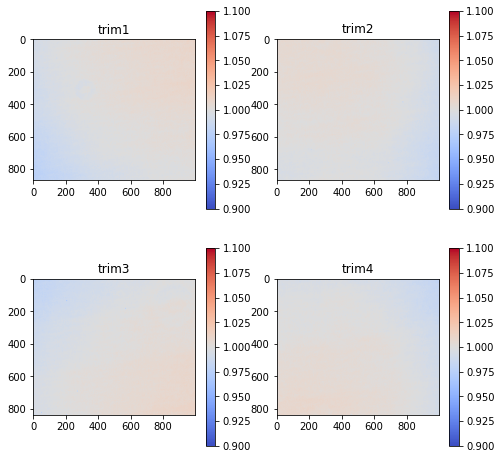

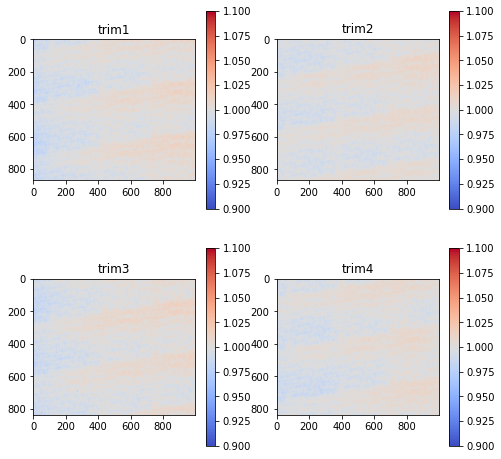

In [13]:
for i_band, iband in enumerate(band):
    trim1 = fits.getdata(path_to_flat+'superflat_'+iband+'_ob_trim1_.fit')
    trim2 = fits.getdata(path_to_flat+'superflat_'+iband+'_ob_trim2_.fit')
    trim3 = fits.getdata(path_to_flat+'superflat_'+iband+'_ob_trim3_.fit')
    trim4 = fits.getdata(path_to_flat+'superflat_'+iband+'_ob_trim4_.fit')

    fig, axs = plt.subplots(2, 2, figsize=(8,8))
    axs[0,0].imshow(trim1,cmap=cm.coolwarm, vmin = 0.9, vmax = 1.1)
    axs[0,0].set_title('trim1')
    fig.colorbar(axs[0,0].imshow(trim1,cmap=cm.coolwarm, vmin = 0.9, vmax = 1.1), ax=axs[0,0])
    axs[0,1].imshow(trim2,cmap=cm.coolwarm, vmin = 0.9, vmax = 1.1)
    axs[0,1].set_title('trim2')
    fig.colorbar(axs[0,1].imshow(trim2,cmap=cm.coolwarm, vmin = 0.9, vmax = 1.1), ax=axs[0,1])
    axs[1,0].imshow(trim3,cmap=cm.coolwarm, vmin = 0.9, vmax = 1.1)
    axs[1,0].set_title('trim3')
    fig.colorbar(axs[1,0].imshow(trim3,cmap=cm.coolwarm, vmin = 0.9, vmax = 1.1), ax=axs[1,0])
    axs[1,1].imshow(trim4,cmap=cm.coolwarm, vmin = 0.9, vmax = 1.1)
    axs[1,1].set_title('trim4')
    fig.colorbar(axs[1,1].imshow(trim4,cmap=cm.coolwarm, vmin = 0.9, vmax = 1.1), ax=axs[1,1])
    plt.show()


In [13]:
path_to_obj

'./RAW/20211202/clusters_XAO/'

In [14]:
flat_median_trim1 = fits.getdata(path_to_flat+'superflat_'+iband+'_ob_trim1_.fit')
flat_median_trim1

array([[0.9834978 , 0.99328303, 0.976843  , ..., 1.0055145 , 1.0010158 ,
        1.0080645 ],
       [0.9682602 , 0.974065  , 0.9946513 , ..., 1.0034622 , 1.0133924 ,
        1.0211875 ],
       [0.9951696 , 0.98834896, 0.98592335, ..., 1.0061573 , 1.0043329 ,
        0.99581224],
       ...,
       [0.9963098 , 0.99490005, 1.0020732 , ..., 1.0048511 , 1.0063231 ,
        1.0278008 ],
       [0.9981342 , 0.99170744, 1.0087279 , ..., 1.0059085 , 1.012667  ,
        1.0071523 ],
       [0.98780996, 0.98326975, 0.9976781 , ..., 1.0199851 , 1.0026743 ,
        0.99199766]], dtype=float32)

In [15]:
path_to_obj+itarget

NameError: name 'itarget' is not defined

In [14]:
#subtract the bias, then divide the flat for each band:

bias = fits.getdata(path_to_bias+'bias.fit')

for i_band, iband in enumerate(band):

    flat_median_trim1 = fits.getdata(path_to_flat+'superflat_'+iband+'_ob_trim1_.fit')
    flat_median_trim2 = fits.getdata(path_to_flat+'superflat_'+iband+'_ob_trim2_.fit')
    flat_median_trim3 = fits.getdata(path_to_flat+'superflat_'+iband+'_ob_trim3_.fit')
    flat_median_trim4 = fits.getdata(path_to_flat+'superflat_'+iband+'_ob_trim4_.fit')

    for i_target, itarget in enumerate(target_name):
        objlist=glob.glob(path_to_obj+itarget+'/*'+iband+'*.fits')

        for i_obj, iobjlist in enumerate(objlist):
            print(iobjlist)
            #continue
            bobj = fits.getdata(iobjlist) - bias
            data_suboverscan = bobj.copy()

            for i_y in range(bobj.shape[0]):
                data_suboverscan[i_y, 0:1000] = data_suboverscan[i_y, 0:1000] - np.median(bobj[i_y, 2001:2030])
                data_suboverscan[i_y, 1000:2000] = data_suboverscan[i_y, 1000:2000] - np.median(bobj[i_y, 2033:2060])

            data_suboverscan_trim1 = data_suboverscan[1001:1870,0:1000] / flat_median_trim1
            data_suboverscan_trim2 = data_suboverscan[1001:1870,1001:2000] / flat_median_trim2
            data_suboverscan_trim3 = data_suboverscan[160:1000,0:1000] / flat_median_trim3
            data_suboverscan_trim4 = data_suboverscan[160:1000,1001:2000] / flat_median_trim4

            fits.writeto(iobjlist.replace(path_to_obj+itarget+'/', path_to_reduc+'fob_trim1_'),data_suboverscan_trim1.astype('float32'),overwrite=True)
            fits.writeto(iobjlist.replace(path_to_obj+itarget+'/', path_to_reduc+'fob_trim2_'),data_suboverscan_trim2.astype('float32'),overwrite=True)
            fits.writeto(iobjlist.replace(path_to_obj+itarget+'/', path_to_reduc+'fob_trim3_'),data_suboverscan_trim3.astype('float32'),overwrite=True)
            fits.writeto(iobjlist.replace(path_to_obj+itarget+'/', path_to_reduc+'fob_trim4_'),data_suboverscan_trim4.astype('float32'),overwrite=True)

        #break



#        fits.writeto(iobjlist.replace(path_to_obj, path_to_reduc+'fb'), ((fits.getdata(iobjlist) - bias)/flat_band).astype('float32'), fits.getheader(iobjlist,0), overwrite=True)



./RAW/20211202/clusters_XAO/NGC2146/NGC2146_Ha_20211202200325_180s_0072.fits
./RAW/20211202/clusters_XAO/NGC2146/NGC2146_Ha_20211202164307_180s_0006.fits
./RAW/20211202/clusters_XAO/NGC2146/NGC2146_Ha_20211202233355_180s_0130.fits
./RAW/20211202/clusters_XAO/NGC2146/NGC2146_Ha_20211202193424_180s_0064.fits
./RAW/20211202/clusters_XAO/NGC2146/NGC2146_Ha_20211202215930_180s_0104.fits
./RAW/20211202/clusters_XAO/NGC2146/NGC2146_Ha_20211202230454_180s_0122.fits
./RAW/20211202/clusters_XAO/NGC2146/NGC2146_Ha_20211202205411_180s_0086.fits
./RAW/20211202/clusters_XAO/NGC2146/NGC2146_Ha_20211202231925_180s_0126.fits
./RAW/20211202/clusters_XAO/NGC2146/NGC2146_Ha_20211202213028_180s_0096.fits
./RAW/20211202/clusters_XAO/NGC2146/NGC2146_Ha_20211202203225_180s_0080.fits
./RAW/20211202/clusters_XAO/NGC2146/NGC2146_Ha_20211202192710_180s_0062.fits
./RAW/20211202/clusters_XAO/NGC2146/NGC2146_Ha_20211202222835_180s_0112.fits
./RAW/20211202/clusters_XAO/NGC2146/NGC2146_Ha_20211202191955_180s_0060.fits

In [15]:
#solve astrometry by astrometry.net:
for i_band, iband in enumerate(band):
    for i_target, itarget in enumerate(target_name):
        objlist = glob.glob(path_to_reduc+'fob_trim*_'+itarget+'*'+iband+'*.fits')
 #       print(objlist)
        for i_obj, iobj in enumerate(objlist):
            #os.system('solve-field  --ra '+target_ra[i_target]+' --dec '+target_dec[i_target]+' --radius 3.5  --scale-units degwidth --scale-low 0.5 --scale-high 2 --no-plots --tweak-order 3 '+iobj)

            print('solve-field  --ra '+target_ra[i_target]+' --dec '+target_dec[i_target]+' --radius 0.5  --scale-units degwidth --scale-low 0.1 --scale-high 0.5 --tweak-order 3 '+iobj)
            os.system('solve-field  --ra '+target_ra[i_target]+' --dec '+target_dec[i_target]+' --radius 0.5  --scale-units degwidth --scale-low 0.1 --scale-high 0.5 --tweak-order 3 '+iobj)

#            break


solve-field  --ra 06:18:37.71 --dec +78:21:25.3 --radius 0.5  --scale-units degwidth --scale-low 0.1 --scale-high 0.5 --tweak-order 3 ./RAW/20211202/reduc/fob_trim1_NGC2146_Ha_20211202191955_180s_0060.fits
solve-field  --ra 06:18:37.71 --dec +78:21:25.3 --radius 0.5  --scale-units degwidth --scale-low 0.1 --scale-high 0.5 --tweak-order 3 ./RAW/20211202/reduc/fob_trim2_NGC2146_Ha_20211202200325_180s_0072.fits
solve-field  --ra 06:18:37.71 --dec +78:21:25.3 --radius 0.5  --scale-units degwidth --scale-low 0.1 --scale-high 0.5 --tweak-order 3 ./RAW/20211202/reduc/fob_trim3_NGC2146_Ha_20211202203940_180s_0082.fits
solve-field  --ra 06:18:37.71 --dec +78:21:25.3 --radius 0.5  --scale-units degwidth --scale-low 0.1 --scale-high 0.5 --tweak-order 3 ./RAW/20211202/reduc/fob_trim4_NGC2146_Ha_20211202215214_180s_0102.fits
solve-field  --ra 06:18:37.71 --dec +78:21:25.3 --radius 0.5  --scale-units degwidth --scale-low 0.1 --scale-high 0.5 --tweak-order 3 ./RAW/20211202/reduc/fob_trim3_NGC2146_Ha_

In [ ]:
#change SIP projection to PV projection:
#this is not necessary if astrometry is solved by SCAMP
for i_band, iband in enumerate(band):
    for i_target, itarget in enumerate(target_name):
        newlist = glob.glob(path_to_reduc+'fob_trim*'+itarget+'*'+iband+'*.new')
        for i_new, inewlist in enumerate(newlist):
            header = fits.getheader(inewlist,0)
            img = fits.getdata(inewlist,0)
            print(inewlist,header['A_ORDER'])
            sip_to_pv.sip_to_pv(header)
            fits.writeto(inewlist+'.wcs.fits', img, header, output_verify="ignore", overwrite=True)    


./RAW/20211202/reduc/fob_trim2_NGC2146_Ha_20211202231925_180s_0126.new 3
./RAW/20211202/reduc/fob_trim3_NGC2146_Ha_20211202195611_180s_0070.new 3
./RAW/20211202/reduc/fob_trim3_NGC2146_Ha_20211202203940_180s_0082.new 3
./RAW/20211202/reduc/fob_trim1_NGC2146_Ha_20211202204656_180s_0084.new 3
./RAW/20211202/reduc/fob_trim4_NGC2146_Ha_20211202203225_180s_0080.new 3
./RAW/20211202/reduc/fob_trim2_NGC2146_Ha_20211202201040_180s_0074.new 3
./RAW/20211202/reduc/fob_trim4_NGC2146_Ha_20211202231209_180s_0124.new 3
./RAW/20211202/reduc/fob_trim2_NGC2146_Ha_20211202200325_180s_0072.new 3
./RAW/20211202/reduc/fob_trim3_NGC2146_Ha_20211202234111_180s_0132.new 3
./RAW/20211202/reduc/fob_trim2_NGC2146_Ha_20211202210127_180s_0088.new 3
./RAW/20211202/reduc/fob_trim1_NGC2146_Ha_20211202165021_180s_0008.new 3
./RAW/20211202/reduc/fob_trim1_NGC2146_Ha_20211202211557_180s_0092.new 3
./RAW/20211202/reduc/fob_trim4_NGC2146_Ha_20211202191955_180s_0060.new 3
./RAW/20211202/reduc/fob_trim3_NGC2146_Ha_202112022

In [ ]:
#remove bg with astnoisechisel
#this is also not necessary
for i_band, iband in enumerate(band):
    for i_target, itarget in enumerate(target_name):
        wcslist = glob.glob(path_to_reduc+'fob_trim*'+itarget+'*'+iband+'*.new.wcs.fits')
        for i_list, iwcslist in enumerate(wcslist):
            os.system('astnoisechisel '+iwcslist+' -h0 -o '+iwcslist.replace('.fits','_detected.fits'))

#for i_list = 0, n_elements(namelist) - 1 do spawn, 'astnoisechisel '+namelist[i_list]+' -h0'


In [ ]:
#make list for swarp
os.system('ulimit -n 1000 ')
for i_band, iband in enumerate(band):
    for i_target, itarget in enumerate(target_name):
        wcslist = glob.glob(path_to_reduc+'fob_trim*'+itarget+'*'+iband+'*.new.wcs_detected.fits')
#        print('fb'+itarget+'*'+iband+'*.new.wcs_detected.fits')
        if wcslist == []:
            continue
        with open(path_to_reduc+itarget+'-'+iband+'.list', 'w') as filesave:
            for i_list, ilist in enumerate(wcslist):
                filesave.write('%s\n' % ilist.replace('fits','fits[1]'))
        os.system('swarp @'+ path_to_reduc+itarget+'-'+iband+'.list'+' -c ./astrofiles/stack.swarp -IMAGEOUT_NAME '+path_to_reduc+target_name[i_target]+'-'+band[i_band]+'.sci.median.fits -RESAMPLING_TYPE BILINEAR -SUBTRACT_BACK N -MEM_MAX 25600 -COMBINE_BUFSIZE 25600')
        print('swarp @'+ path_to_reduc+itarget+'-'+iband+'.list'+' -c ./astrofiles/stack.swarp -IMAGEOUT_NAME '+path_to_reduc+target_name[i_target]+'-'+band[i_band]+'.sci.median.fits -RESAMPLING_TYPE BILINEAR -SUBTRACT_BACK N -MEM_MAX 25600 -COMBINE_BUFSIZE 25600')


swarp @./RAW/20211202/reduc/NGC2146-Ha.list -c ./astrofiles/stack.swarp -IMAGEOUT_NAME ./RAW/20211202/reduc/NGC2146-Ha.sci.median.fits -RESAMPLING_TYPE BILINEAR -SUBTRACT_BACK N -MEM_MAX 25600 -COMBINE_BUFSIZE 25600
swarp @./RAW/20211202/reduc/LC01-Ha.list -c ./astrofiles/stack.swarp -IMAGEOUT_NAME ./RAW/20211202/reduc/LC01-Ha.sci.median.fits -RESAMPLING_TYPE BILINEAR -SUBTRACT_BACK N -MEM_MAX 25600 -COMBINE_BUFSIZE 25600
swarp @./RAW/20211202/reduc/NGC2146-B.list -c ./astrofiles/stack.swarp -IMAGEOUT_NAME ./RAW/20211202/reduc/NGC2146-B.sci.median.fits -RESAMPLING_TYPE BILINEAR -SUBTRACT_BACK N -MEM_MAX 25600 -COMBINE_BUFSIZE 25600
